In [ ]:
versioninfo(verbose=true)

In [ ]:
using Pkg 
Pkg.activate(".")

In [ ]:
Pkg.status()

In [4]:
pwd()

"/run/media/tuffty/Data1/Projects/krastanov_lab/winter2025/QEPOptimize/QuantumHardware"

In [5]:
# using Revise
# include("../src/BPNoise/noise_interfaces.jl")
# include("../src/BPNoise/amplitude_damping_error.jl")
# include("../src/BPNoise/asymm_dep_error.jl")
# include("../src/BPNoise/mock_noise_information.jl")
# include("../src/BPNoise/phase_damping_error.jl")
# include("../src/BPNoise/noise_model.jl")
# include("../src/BPNoise/ibm_quantum_backend.jl")
# include("../src/qevo_optimizer.jl")

In [3]:
using Revise
using QEPO
# includet("genetic_optimizer.jl")
# includet("circuit_plotting.jl")
# includet("performance_plotting.jl")

In [4]:
read_calibration_data

read_calibration_data (generic function with 1 method)

In [ ]:
valid_qubits = ([ 43, 44, 45, 46, 47,  48, 49, 50])
valid_qubits

In [5]:
ibmqc = "ibmq_sherbrooke"
calibration_data = read_calibration_data("ibm_sherbrooke_calibrations_2024-10-09.csv")


Dict{Any, Any} with 273 entries:
  (84, 83)   => (two_qubit_error = 0.00510895, gate_time = 5.10895e-12)
  56         => (T1 = 0.000173462, T2 = 1.69325e-5, readout_error = 0.0333333)
  35         => (T1 = 0.000205989, T2 = 5.68853e-5, readout_error = 0.0123)
  (17, 12)   => (two_qubit_error = 0.00850076, gate_time = 8.50076e-12)
  (104, 103) => (two_qubit_error = 0.0080306, gate_time = 8.0306e-12)
  60         => (T1 = 0.000320243, T2 = 0.00039468, readout_error = 0.0094)
  (117, 118) => (two_qubit_error = 0.00593336, gate_time = 5.93336e-12)
  (125, 124) => (two_qubit_error = 0.00759903, gate_time = 7.59903e-12)
  (7, 8)     => (two_qubit_error = 0.0206738, gate_time = 2.06738e-11)
  67         => (T1 = 0.000213432, T2 = 0.000179403, readout_error = 0.0255)
  73         => (T1 = 0.000230552, T2 = 0.000144337, readout_error = 0.0152)
  (25, 24)   => (two_qubit_error = 0.00873902, gate_time = 8.73902e-12)
  (89, 74)   => (two_qubit_error = 0.00665568, gate_time = 6.65568e-12)
  115    

In [7]:
typeof(calibration_data)

Dict{Any, Any}

In [ ]:
# Let's break down the key components of the simulation process, which can be summarized as 5 steps 

################################################
##     choose SC quantum computer and path    ##
################################################

# The first step is to choose the quantum computer we want to use for our simulations. 
# In this example, we’re working with IBM’s superconducting quantum computers, here i showcased two examples 
# Monte Carlo Simulation for calculating the performance of circuits 
num_simulations = 10000

# read the calibration data and Define the valid qubits

# Ex1: 27-qubit ibmq_kolkata
# ibmqc = "ibmq_kolkata"
# calibration_data = read_calibration_data("ibmq_kolkata_calibrations_2024-02-02.csv")
# measurement_duration = 1216e-9
# gate_times = 533e-9
# valid_qubits = ([ 4, 7, 10, 12, 15, 18])                  # select path (6 qubits) with high fidelity 
# valid_qubits = ([ 1, 4, 7, 10, 12, 15, 18, 21])           # select path (8 qubits) with high fidelity 

# Ex2: 127-qubit ibmq_sherbrooke
ibmqc = "ibmq_sherbrooke"
calibration_data = read_calibration_data("ibm_sherbrooke_calibrations_2024-10-09.csv")
t1 = 286e-6
t2 = 251e-6
gate_times = 533e-9
measurement_duration = 640e-9
# valid_qubits = ([ 43, 44, 45, 46, 47,  48])
valid_qubits = ([ 43, 44, 45, 46, 47,  48, 49, 50])
# valid_qubits = ([ 42, 43, 44, 45, 46, 47,  48, 49, 50, 51])

# For this simulation, we select 6-10 qubits from ibmq_sherbrooke.
# Calibration data for ibmq_sherbrooke is read from a file, and we focus on valid qubits that exhibit the lowest error rates.

# noise_model = create_T1_T2_noise_model(calibration_data, valid_qubits, measurement_duration, gate_times)

##################################
## initialization of population ##
##################################

# Next, we initialize the population of quantum circuits for optimization. Here’s what we define:
n = 6                                # number of raw bell pairs
k = 1                                # number of purified pairs
r = 4                                # number of registers (length of the valid_qubits)
optimize_for = CostFunction(1)       # 0: logical_qubit_fidelity  1: purified_pairs_fidelity 2 : average_marginal_fidelity
code_distance = 3                    # for logical_qubit_fidelity
f_in = 0.90                          # fidelity that being generated at communication qubits 
                                     # f_in = 0.9 would be appropriate

########################################
##  parameters for genetic algorithm  ##
########################################

starting_ops = 17                    # should be adapted to r  
max_ops = 17                         # should be appropriate!
population_size = 20                 # target population after distillation 
starting_pop_multiplier = 200        # multiplier 20 or 200
max_gen = 20

pairs = 20
children_per_pair = 3
mutants_per_individual_per_type = 5

p_lose_operation = 0.9
p_add_operation = 0.7
p_swap_operations = 0.8
p_mutate_operations = 0.8
individuals = []
selection_history = Dict()

# tips for tunning the parameters
# 1. 
# 2. 
# 3. 

############################
##  optimization process  ##
############################

# Once the population is initialized, the optimization process begins. 
population = Population_hardware(n, k, r, code_distance, optimize_for, f_in, population_size, starting_pop_multiplier, max_gen, max_ops, starting_ops, pairs, children_per_pair, mutants_per_individual_per_type, p_lose_operation, p_add_operation, p_swap_operations, p_mutate_operations, individuals, selection_history, num_simulations)

# We run the genetic algorithm with constraints derived from the calibration data and the valid qubit paths we defined earlier.

# run_with_constraints!(population, calibration_data, valid_qubits)
run_with_constraints_history!(population, calibration_data, valid_qubits)



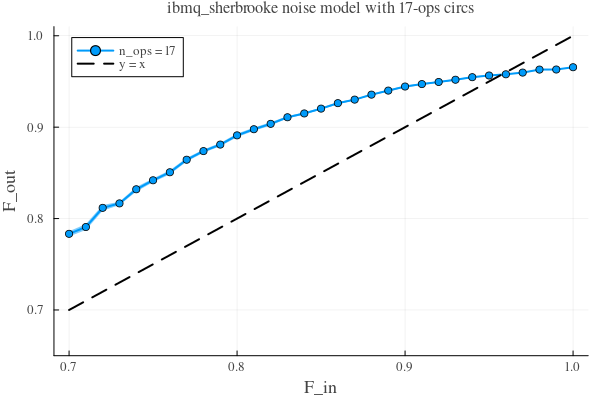

In [10]:
#############################################################
# plot the output fidelities for different input fidilities #
#############################################################

# After the optimization, we use dataframes to analyze the performance of the circuits. 
# Specifically, we plot the output fidelities for different input fidelities to see how well the circuits perform under varying conditions:

# dataframe info
num_individuals = 20 
f_ins = 0.7:0.01:1.0 

df = generate_dataframe_without_p2s(population, num_individuals, f_ins, num_simulations)

title = "$ibmqc noise model with $max_ops-ops circs"
plot_purified_pairs_fidelity(df, title, max_ops)

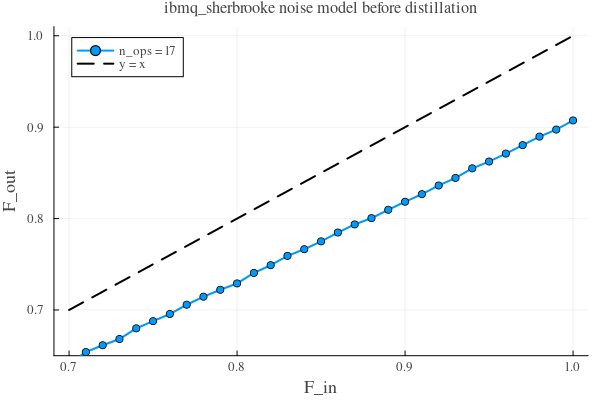

In [11]:
## fidelities of long-range bell pair before distillation 

population_before = Population_hardware(n, k, r, code_distance, optimize_for, f_in, population_size, starting_pop_multiplier, max_gen, max_ops, starting_ops, pairs, children_per_pair, mutants_per_individual_per_type, p_lose_operation, p_add_operation, p_swap_operations, p_mutate_operations, individuals, selection_history, num_simulations)

long_range_entanglement_generation!(population_before, calibration_data, valid_qubits)

df_before = generate_dataframe_without_p2s(population_before, num_individuals, f_ins, num_simulations)

title_2 = "$ibmqc noise model before distillation"
plot_purified_pairs_fidelity(df_before, title_2, max_ops)

In [12]:
###############################################################
## Performance of optimized circuits across varying max_ops  ##
###############################################################

# Define the list of `max_ops` values
max_ops_values = [13, 15, 17, 19]
num_individuals = 20 
f_ins = 0.7:0.01:1.0 
title = "$ibmqc noise model with $r available registers and $n raw bell pairs"

for max_ops in max_ops_values

    population = Population_hardware(n, k, r, code_distance, optimize_for, f_in, population_size, starting_pop_multiplier, max_gen, max_ops, starting_ops, pairs, children_per_pair, mutants_per_individual_per_type, p_lose_operation, p_add_operation, p_swap_operations, p_mutate_operations, individuals, selection_history, num_simulations)
    run_with_constraints_history!(population, calibration_data, valid_qubits)
    df = generate_dataframe_without_p2s(population, num_individuals, f_ins, num_simulations)
    plot_purified_pairs_fidelity(df, title, max_ops)

end 

LoadError: TaskFailedException

[91m    nested task error: [39mInterruptException:
    Stacktrace:
     [1] [0m[1mindexed_iterate[22m
    [90m   @[39m [90m./[39m[90m[4mtuple.jl:92[24m[39m[90m [inlined][39m
     [2] [0m[1mindexed_iterate[22m[0m[1m([22m[90mt[39m::[0mTuple[90m{BellState, CircuitStatus}[39m, [90mi[39m::[0mInt64[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mtuple.jl:92[24m[39m
     [3] [0m[1mmctrajectory![22m[0m[1m([22m[90mstate[39m::[0mBellState, [90mcircuit[39m::[0mVector[90m{Union{NoisyBellMeasureNoisyReset, PauliNoiseBellGate{BellSwap}, PauliNoiseBellGate{CNOTPerm}, T1NoiseOp, T2NoiseOp}}[39m[0m[1m)[22m
    [90m   @[39m [36mQuantumClifford[39m [90m~/.julia/packages/QuantumClifford/QzuTR/src/[39m[90m[4mmctrajectory.jl:43[24m[39m
     [4] [0m[1mcalculate_performance![22m[0m[1m([22m[90mindiv[39m::[0mIndividual, [90mnum_simulations[39m::[0mInt64[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90m~/Desktop/Entanglement Purification/code/qevo_optimizer_improved/QuantumHardware/[39m[90m[4mgenetic_optimizer.jl:291[24m[39m
     [5] [0m[1mmacro expansion[22m
    [90m   @[39m [90m~/Desktop/Entanglement Purification/code/qevo_optimizer_improved/QuantumHardware/[39m[90m[4mgenetic_optimizer.jl:654[24m[39m[90m [inlined][39m
     [6] [0m[1m(::var"#118#threadsfor_fun#61"{var"#118#threadsfor_fun#59#62"{Population_hardware, Vector{Individual}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [7] [0m[1m#118#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [8] [0m[1m(::Base.Threads.var"#1#2"{var"#118#threadsfor_fun#61"{var"#118#threadsfor_fun#59#62"{Population_hardware, Vector{Individual}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

In [ ]:
################################################################################
## Performance of optimized circuits across varying number of raw bell pair   ##
################################################################################

# Define the list of `max_ops` values
n_values = [6,8,10]
num_individuals = 20 
f_ins = 0.7:0.01:1.0 
title = "$ibmqc noise model with $r registers and $max_ops ops"

for n in n_values

    population = Population_hardware(n, k, r, code_distance, optimize_for, f_in, population_size, starting_pop_multiplier, max_gen, max_ops, starting_ops, pairs, children_per_pair, mutants_per_individual_per_type, p_lose_operation, p_add_operation, p_swap_operations, p_mutate_operations, individuals, selection_history, num_simulations)
    run_with_constraints_history!(population, calibration_data, valid_qubits)
    df = generate_dataframe_without_p2s(population, num_individuals, f_ins, num_simulations)
    plot_purified_pairs_fidelity(df, title, n)

end 

In [ ]:
###########################################################################
## Performance of optimized circuits across varying number of registers  ##
###########################################################################

# Define the list of `max_ops` values
r_values = [3,4,5]
num_individuals = 20 
f_ins = 0.7:0.01:1.0 
title = "$ibmqc noise model with $r registers"

for r in r_values

    population = Population_hardware(n, k, r, code_distance, optimize_for, f_in, population_size, starting_pop_multiplier, max_gen, max_ops, starting_ops, pairs, children_per_pair, mutants_per_individual_per_type, p_lose_operation, p_add_operation, p_swap_operations, p_mutate_operations, individuals, selection_history, num_simulations)
    run_with_constraints_history!(population, calibration_data, valid_qubits)
    df = generate_dataframe_without_p2s(population, num_individuals, f_ins, num_simulations)
    plot_purified_pairs_fidelity(df, title, n)

end 

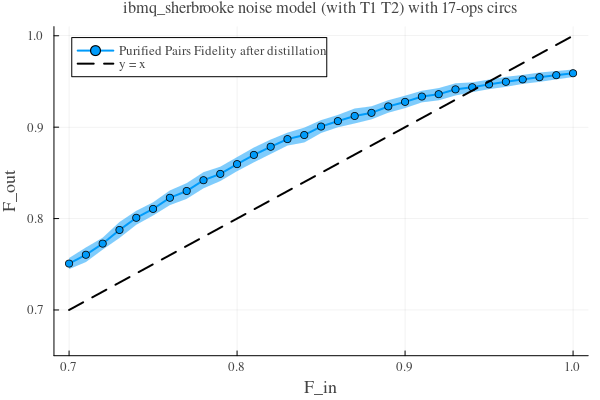

In [28]:
#############################################################
# plot the output fidelities for different input fidilities #
#############################################################

# After the optimization, we use dataframes to analyze the performance of the circuits. 
# Specifically, we plot the output fidelities for different input fidelities to see how well the circuits perform under varying conditions:

# dataframe info
num_individuals = 20 
f_ins = 0.7:0.01:1.0 

df = generate_dataframe_without_p2s(population, num_individuals, f_ins, num_simulations)

title = "$ibmqc noise model with $max_ops-ops circs"
plot_purified_pairs_fidelity(df, title, max_ops)

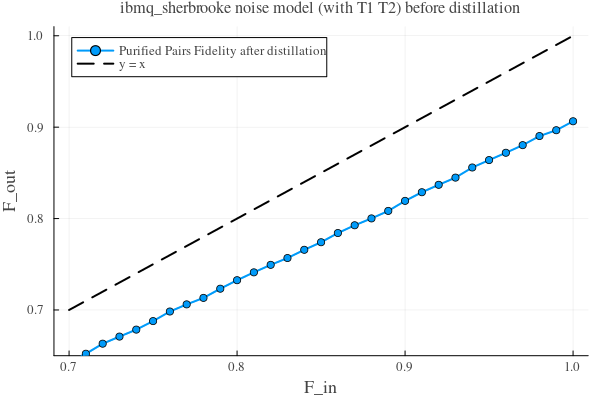

In [30]:
## fidelities of long-range bell pair before distillation 

population_before = Population_hardware(n, k, r, code_distance, optimize_for, f_in, population_size, starting_pop_multiplier, max_gen, max_ops, starting_ops, pairs, children_per_pair, mutants_per_individual_per_type, p_lose_operation, p_add_operation, p_swap_operations, p_mutate_operations, individuals, selection_history, num_simulations)

long_range_entanglement_generation!(population_before, calibration_data, valid_qubits)

df_before = generate_dataframe_without_p2s(population_before, num_individuals, f_ins, num_simulations)

title_2 = "$ibmqc noise model before distillation"
plot_purified_pairs_fidelity(df_before, title_2)

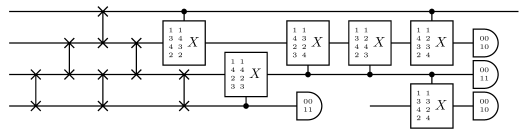

In [38]:
population.individuals[10].ops 

In [39]:
print(population.individuals[10].ops)

Union{NoisyBellMeasureNoisyReset, PauliNoiseBellGate{BellSwap}, PauliNoiseBellGate{CNOTPerm}}[PauliNoiseBellGate{BellSwap}(BellSwap(4, 3), 0.008382719809533715, 0.008382719809533715, 0.008382719809533715), PauliNoiseBellGate{BellSwap}(BellSwap(3, 2), 0.008854846264460238, 0.008854846264460238, 0.008854846264460238), PauliNoiseBellGate{BellSwap}(BellSwap(2, 1), 0.009904959580707464, 0.009904959580707464, 0.009904959580707464), PauliNoiseBellGate{BellSwap}(BellSwap(4, 3), 0.008382719809533715, 0.008382719809533715, 0.008382719809533715), PauliNoiseBellGate{BellSwap}(BellSwap(3, 2), 0.008854846264460238, 0.008854846264460238, 0.008854846264460238), PauliNoiseBellGate{BellSwap}(BellSwap(4, 3), 0.008382719809533715, 0.008382719809533715, 0.008382719809533715), PauliNoiseBellGate{CNOTPerm}(CNOTPerm(5, 5, 4, 3), 0.002578783582392321, 0.002578783582392321, 0.002578783582392321), PauliNoiseBellGate{CNOTPerm}(CNOTPerm(4, 6, 1, 2), 0.0033067465712277007, 0.0033067465712277007, 0.00330674657122770

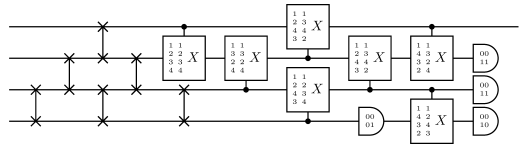

In [34]:
displaycircuit(population.individuals[3].ops)

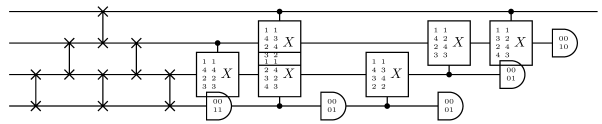

In [52]:
population.individuals[10].ops

In [35]:
# Save the DataFrame to a CSV file depending the optimized result 
CSV.write("exp_swap_$r to1_ $max_ops ops_$ibmqc _withT1T2.csv", df)

"exp_swap_4 to1_ 17 ops_ibmq_sherbrooke _withT1T2.csv"

Performance[Performance([1.0, 0.0], 1.0, 1.0, 1.0, 0.001), Performance([0.9402985074626866, 0.05970149253731343], 0.9402985074626866, 1.0, 0.9402985074626866, 0.335), Performance([0.9264705882352942, 0.07352941176470588], 0.9264705882352942, 1.0, 0.9264705882352942, 0.34), Performance([0.926829268292683, 0.07317073170731707], 0.926829268292683, 1.0, 0.926829268292683, 0.369), Performance([0.9260355029585798, 0.07396449704142012], 0.9260355029585798, 1.0, 0.9260355029585798, 0.338), Performance([0.9297297297297298, 0.07027027027027027], 0.9297297297297298, 1.0, 0.9297297297297298, 0.37), Performance([0.9559748427672956, 0.0440251572327044], 0.9559748427672956, 1.0, 0.9559748427672956, 0.159), Performance([0.9198813056379822, 0.08011869436201781], 0.9198813056379822, 1.0, 0.9198813056379822, 0.337), Performance([0.9563953488372093, 0.0436046511627907], 0.9563953488372093, 1.0, 0.9563953488372093, 0.344), Performance([0.9470588235294117, 0.052941176470588235], 0.9470588235294117, 1.0, 0.9

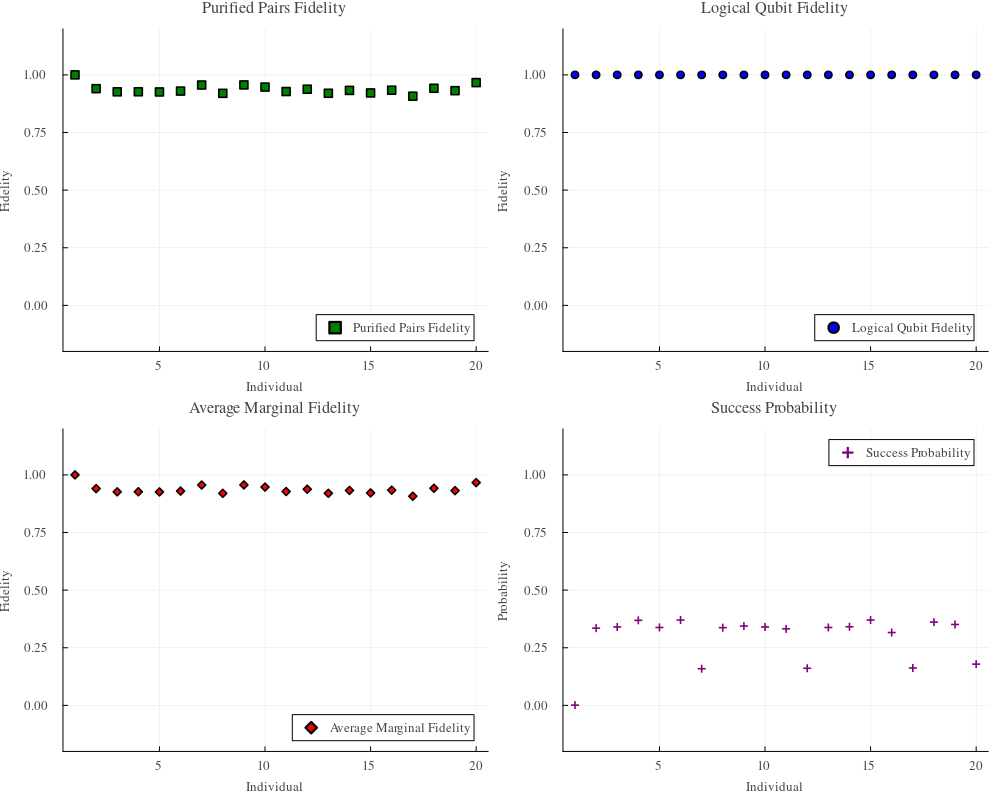

In [36]:

# Visualize the performance metrics of single generation 
performances = [calculate_performance!(indiv, 1000) for indiv in population.individuals]    # 
print(performances)
plot_performance_metrics(performances)


In [ ]:
# plot the data saved in CSV file 
using CSV
using DataFrames
CSV.read("exp_swap_$r to1_ $max_ops ops_$ibmqc _withT1T2.csv", DataFrame)